# Юнит 6. Предсказание стоимости автомобиля
## Цель: по данным автомобиля предсказать его стоимость



**Дано:**

- Дата сет с параметрами автомобилей BMW, из регионов Москва и Московская область, без цен.

**План работы:**

- Собрать дата сет для обучения модели.
- Провести предобработку данных, анализ и создание/удаление признаков (EDA).
- Провести выбор моделей для обучения.
- Подобрать гиперпараметры моделей.
- Объединить модели в стек для получения оптимального результата.
- На этапах тестирования использовать кросс-валидацию.

## 1. Загрузим библиотеки

In [258]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import sys
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Используемые функции

### Построение диаграмм и графиков

In [2]:
# Графики для числовых параметров
def get_gr_num(df, col, bns=10):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style="darkgrid")

    sns.distplot(df[col], bins=bns)
    axes.set_title(col)

In [3]:
# Количество
def get_gr_counts(df, col):
    print('Признак ', col)
    print()
    print(df[col].value_counts())
    print()
    print()
    df[col].value_counts(ascending=True).plot(
        kind='barh', title=col, cmap='coolwarm')

### Обработка признаков

In [4]:
# Обработка признака 'name'
def get_model_from_name(string):
    string = string.replace(' 4WD', '')
    s_list = string.split(' ')
    n = len(s_list)
    if n == 7:
        return str(s_list[0])+str(s_list[1])+str(s_list[2])
    elif n == 6:
        return str(s_list[0])+str(s_list[1])
    elif n == 5:
        return str(s_list[0])
    else:
        return None

## Исходные данные

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 25

In [6]:
VERSION = 20200905

# подключил к ноутбуку свой внешний датасет auto_ru_05092020_BMW_4_districts.csv
DIR_TRAIN = '../input/train10092020/'
DIR_TEST = '../input/sf-dst-car-price/'
VAL_SIZE = 0.33   # 33%
N_FOLDS = 5

# CATBOOST
ITERATIONS = 2000
LR = 0.1

In [7]:
!ls ../input/

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [8]:
# выведем побольше колонок и строк
max_columns = 30
max_rows = 30
pd.set_option('display.max_columns', max_columns)
pd.set_option('display.max_rows', max_rows)

In [132]:
# подготовленный датасет для обучения модели
train = pd.read_csv('C:/Users/1311959/Desktop/python/auto_ru_05092020_BMW_4_districts.csv')
test = pd.read_csv('C:/Users/1311959/Desktop/python/test.csv')
sample_submission = pd.read_csv('C:/Users/1311959/Desktop/python/sample_submission.csv')

## 3. EDA

In [133]:
test.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \n\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [11]:
train.head(5)

,district_id,region_id,bodyType,brand,model,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Владельцы,ПТС,Таможня,Владение,Price
0,3,10687,Хэтчбек 5 дв.,BMW,1ER,040001,бензин,2011,116i 1.6 AT (136 л.с.),5,2012,AUTOMATIC,116i,136,NaN,78000,"{'id': '7707468', 'name': '116i', 'available_o...",задний,LEFT,3.0,ORIGINAL,True,"{'year': 2017, 'month': 8}",570000.0
1,3,10687,Седан,BMW,3ER,0000CC,дизель,2011,320d xDrive 2.0d AT (184 л.с.) 4WD,4,2014,AUTOMATIC,320d,184,"Полностью обслужена ,покрыта керамикой, хороша...",86000,{'id': '0'},полный,LEFT,3.0,ORIGINAL,True,NaN,1150000.0
2,3,10687,Седан,BMW,3ER,22A0F8,бензин,2011,320i xDrive 2.0 AT (184 л.с.) 4WD,4,2014,AUTOMATIC,320i,184,"Авто в отличном состоянии, М-пакет, салон альк...",80000,{'id': '0'},полный,LEFT,2.0,ORIGINAL,True,NaN,1140000.0
3,3,10687,Седан,BMW,3ER,FAFBFB,бензин,2008,318i 2.0 AT (136 л.с.),4,2011,AUTOMATIC,318i,136,Устранены оснавные болячки. Заменён гидротранс...,156000,{'id': '0'},задний,LEFT,3.0,ORIGINAL,True,NaN,550000.0
4,3,10687,Седан,BMW,3ER,0000CC,бензин,2001,318i 2.0 AT (143 л.с.),4,2002,AUTOMATIC,318i,143,Авто в исправном состоянии есть недочёты по ку...,240350,{'id': '0'},задний,LEFT,3.0,ORIGINAL,True,NaN,250000.0


### Пропуски

In [134]:
# Смотрим на пропуски
train.isnull().sum()

district_id                 0
region_id                   0
bodyType                    0
brand                       0
model                       0
color                       0
fuelType                    0
modelDate                   0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
engineDisplacement          0
enginePower                 0
description               532
mileage                     0
Комплектация                0
Привод                      0
Руль                        0
Владельцы                2756
ПТС                       197
Таможня                     0
Владение                12737
Price                      69
dtype: int64

In [135]:
# Смотрим на пропуски
test.isnull().sum()

bodyType                   0
brand                      0
color                      0
fuelType                   0
modelDate                  0
name                       0
numberOfDoors              0
productionDate             0
vehicleConfiguration       0
vehicleTransmission        0
engineDisplacement         0
enginePower                0
description                0
mileage                    0
Комплектация               0
Привод                     0
Руль                       0
Состояние                  0
Владельцы                  0
ПТС                        0
Таможня                    0
Владение                2084
id                         0
dtype: int64

Выделяем отдельно пропуски

In [136]:
train['description_Nan'] = pd.isna(train['description']).astype('uint8')
train['owners_Nan'] = pd.isna(train['Владельцы']).astype('uint8')
train['pts_Nan'] = pd.isna(train['ПТС']).astype('uint8')

test['description_Nan'] = pd.isna(test['description']).astype('uint8')
test['owners_Nan'] = pd.isna(test['Владельцы']).astype('uint8')
test['pts_Nan'] = pd.isna(test['ПТС']).astype('uint8')

### изучение целевой переменной


- Переименуем Price в price
- Удалим строки с пропусками.
- Поменяем тип на 'int' для правильной работы классификатора 'Cat boost'.

In [137]:
train.rename(columns={'Price': 'price'}, inplace=True)
train = train.dropna(subset=['price'], axis=0)
train['price'] = train['price'].astype('int64')

**Посмотрим распределение целевой переменной**

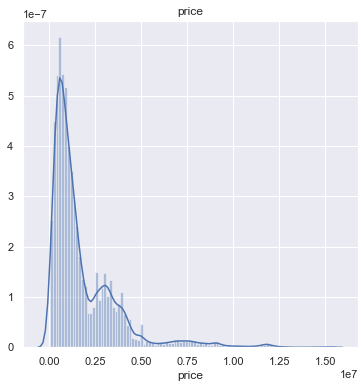

In [138]:
get_gr_num(train, 'price', 100)

**Вывод:** Распределение не является нормальным, возможно его следует прологарифмировать

## Сравним признаки в train и test
И приведем их в соответствие друг другу для последующего объединения датасетов

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17555 entries, 0 to 17623
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_id           17555 non-null  int64  
 1   region_id             17555 non-null  int64  
 2   bodyType              17555 non-null  object 
 3   brand                 17555 non-null  object 
 4   model                 17555 non-null  object 
 5   color                 17555 non-null  object 
 6   fuelType              17555 non-null  object 
 7   modelDate             17555 non-null  int64  
 8   name                  17555 non-null  object 
 9   numberOfDoors         17555 non-null  int64  
 10  productionDate        17555 non-null  int64  
 11  vehicleConfiguration  17555 non-null  object 
 12  engineDisplacement    17555 non-null  object 
 13  enginePower           17555 non-null  int64  
 14  description           17026 non-null  object 
 15  mileage            

In [140]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

In [141]:
set(train.columns) - set(test.columns)

{'district_id', 'model', 'price', 'region_id'}

В **test** отсутствуют параметры: **'district_id', 'model', 'price', 'region_id'** - поработаем с ними.

In [142]:
# Добавим недостоющие столбцы для совместной обработки датасетов test & train
test['price'] = 0
test['district_id'] = 3  # Код Центрального федерального региона
test['region_id'] = 1  # Код Москвы и МО

In [143]:
test['model'] = test['name'].apply(get_model_from_name)
test['model']

0             520d
1             318d
2       550ixDrive
3              30d
4             M50d
           ...    
3832          520i
3833           30d
3834         525xi
3835    528ixDrive
3836           50i
Name: model, Length: 3837, dtype: object

Проведем обратную проверку признаков

In [144]:
set(test.columns) - set(train.columns)

{'id', 'vehicleTransmission', 'Состояние'}

В **train** отсутствуют параметры: **'id', 'vehicleTransmission', 'Состояние'**

Удалим признаки **'id'** и **'Состояние'**, т. к. они не несут уникальной информации.

In [145]:
test = test.drop(['Состояние', 'id'], axis=1)

### Посмотрим на признак 'vehicleTransmission'

Признак  vehicleTransmission

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64




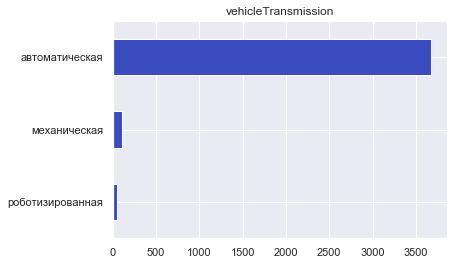

In [146]:
get_gr_counts(test, 'vehicleTransmission')

- Дальнейшая обработка данных показала, что данный признак дублирует информацию, существующую в других признаках. Удалим его, как избыточный.

In [147]:
test = test.drop(['vehicleTransmission'], axis=1)

### Признак 'bodyType'

Признак  bodyType

внедорожник 5 дв.    1626
седан                1594
купе                  214
хэтчбек 5 дв.         163
лифтбек               125
универсал 5 дв.        46
хэтчбек 3 дв.          36
кабриолет              19
родстер                10
компактвэн              3
седан 2 дв.             1
Name: bodyType, dtype: int64




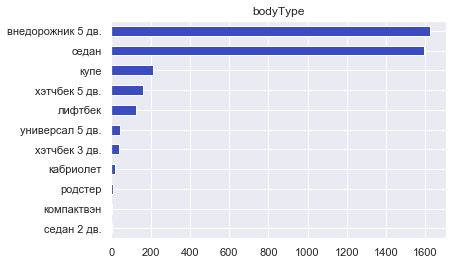

In [148]:
get_gr_counts(test, 'bodyType')

Признак  bodyType

Седан                     7828
Внедорожник 5 дв.         6780
Купе                       675
Седан Long                 547
Хэтчбек 5 дв.              541
Лифтбек Gran Turismo       348
Седан Gran Coupe           246
Универсал 5 дв.            178
Хэтчбек 3 дв.              128
Кабриолет                  112
Родстер                     49
Хэтчбек 3 дв. Compact       48
Седан 2 дв.                 27
Лифтбек Gran Coupe          23
Компактвэн Gran Tourer      10
Купе-хардтоп                 7
Компактвэн                   7
Родстер Roadster             1
Name: bodyType, dtype: int64




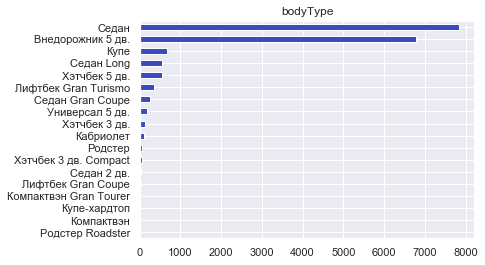

In [149]:
get_gr_counts(train, 'bodyType')

- Заменим в train названия на строчные буквы, как в test.
- Приведем в соответствие значения в train значениям в test
- Удалить из трейна то, чего нет в тесте (потеряем часть строк, но уберем то, чего нет в данных, на которых будем проверять модель, меньше мусора в процессе обучения).


In [150]:
# Заменим всё на строчные буквы
train['bodyType'] = train['bodyType'].apply(lambda x: x.lower())

In [151]:
filt = set(train['bodyType']) - set(test['bodyType'])
filt

{'компактвэн gran tourer',
 'купе-хардтоп',
 'лифтбек gran coupe',
 'лифтбек gran turismo',
 'родстер roadster',
 'седан gran coupe',
 'седан long',
 'хэтчбек 3 дв. compact'}

Создадим индикатор в train по отличающимся значениям, для последующей фильтрации.

In [152]:
train['filter_1'] = 0
test['filter_1'] = 0
train['filter_1'] = train['bodyType'].apply(lambda x: 1 if x in filt else 0)
train['filter_1'].value_counts()

0    16325
1     1230
Name: filter_1, dtype: int64

Приведем названия в train в соответствие с test

In [153]:
body_type_dict = {
    'компактвэн gran tourer': 'компактвэн',
    'купе-хардтоп': 'купе',
    'лифтбек gran coupe': 'лифтбек',
    'лифтбек gran turismo': 'лифтбек',
    'родстер roadster': 'родстер',
    'седан gran coupe': 'седан',
    'седан long': 'седан',
    'хэтчбек 3 дв. compact': 'хэтчбек 3 дв.'
}

train['bodyType'] = train['bodyType'].replace(to_replace=body_type_dict)

### Признак 'brand'
На первом этапе работаем только с BMW, поэтому признак не несет уникальной информации. Удалим его.

In [154]:
test = test.drop(['brand'], axis=1)
train = train.drop(['brand'], axis=1)

### Признак 'color'

Признак  color

040001    6858
FAFBFB    3301
97948F    2109
0000CC    2084
CACECB    1219
EE1D19     549
200204     480
007F00     350
C49648     161
22A0F8     148
DEA522     100
FF8649      80
660099      63
4A2197      42
FFD600       9
FFC0CB       2
Name: color, dtype: int64




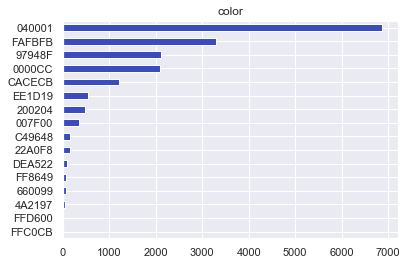

In [155]:
get_gr_counts(train, 'color')

Признак  color

чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64




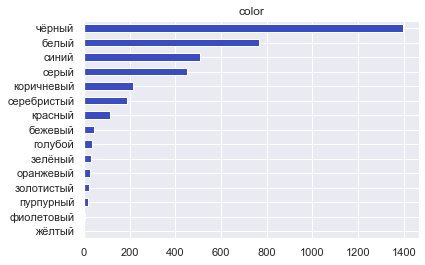

In [156]:
get_gr_counts(test, 'color')

Переведем технические сокращения цветов в человекопонятный вид в train

In [157]:
# замена цвета в train
hex_color = {
    '040001': 'чёрный',
    'FAFBFB': 'белый',
    '0000CC': 'синий',
    '97948F': 'серый',
    'CACECB': 'серебристый',
    '200204': 'коричневый',
    'EE1D19': 'красный',
    '007F00': 'зелёный',
    '22A0F8': 'голубой',
    'C49648': 'бежевый',
    'FF8649': 'оранжевый',
    'DEA522': 'золотистый',
    '4A2197': 'фиолетовый',
    '660099': 'пурпурный',
    'FFD600': 'жёлтый',
    'FFC0CB': 'розовый'
}

train['color'].replace(hex_color, inplace=True)

### Признак 'fuelType'

Признак  fuelType

бензин     11939
дизель      5561
гибрид        42
электро       13
Name: fuelType, dtype: int64




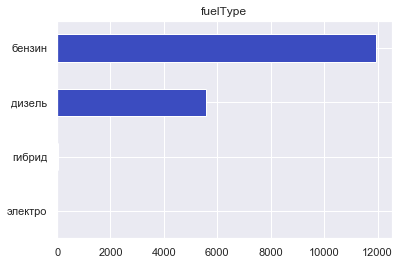

In [158]:
get_gr_counts(train, 'fuelType')

Признак  fuelType

бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64




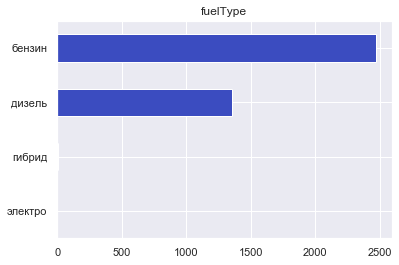

In [159]:
get_gr_counts(test, 'fuelType')

**Предварительный вывод:** Полностью соответствуют, обработка пока не требуется.

### Признак 'modelDate'
Год начала производства данной модели авто.
- Переведем тип данных в int.
- Попробовать логарифмировать признак.

Посмотрим на года моделей, которые есть в train, но отсутствуют в test. Варианты дальнейшей работы с этими данными:
- Удалить из трейна то, чего нет в тесте (потеряем часть строк, но уберем то, чего нет в данных, на которых будем проверять модель, меньше мусора в процессе обучения).
- Оставить признаки в трейне, как есть (сохранятся строки, и по этому признаку будет различие в выборках).

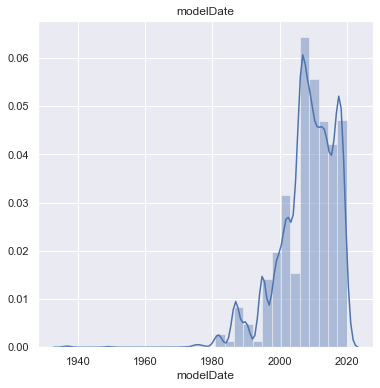

In [160]:
get_gr_num(train, 'modelDate', 30)

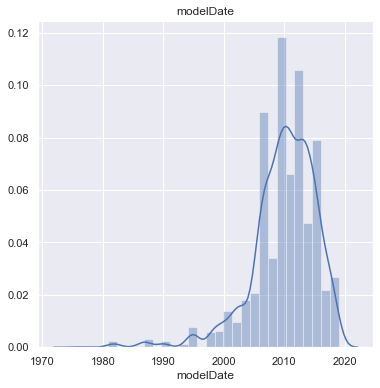

In [161]:
get_gr_num(test, 'modelDate', 30)

In [162]:
test['modelDate'] = test['modelDate'].astype('int64')
filt = set(train['modelDate']) - set(test['modelDate'])
filt

{1936, 1937, 1949, 1966, 1968, 1972, 1976, 1988, 1989, 1992, 1997, 2020}

Создадим индикатор в train по отличающимся значениям, для последующей фильтрации.

In [163]:
train['filter_2'] = 0
test['filter_2'] = 0
train['filter_2'] = train['modelDate'].apply(lambda x: 1 if x in filt else 0)
train['filter_2'].value_counts()

0    17301
1      254
Name: filter_2, dtype: int64

### Признак 'name'
В признаке очень много информации различных типов. Вытащим её в отдельные признаки.

In [164]:
train['d_in_name'] = train['name'].apply(lambda x: 1 if 'd' in x else 0)
test['d_in_name'] = test['name'].apply(lambda x: 1 if 'd' in x else 0)

train['i_in_name'] = train['name'].apply(lambda x: 1 if 'i' in x else 0)
test['i_in_name'] = test['name'].apply(lambda x: 1 if 'i' in x else 0)

train['4WD_in_name'] = train['name'].apply(lambda x: 1 if '4WD' in x else 0)
test['4WD_in_name'] = test['name'].apply(lambda x: 1 if '4WD' in x else 0)

train['xDrive_in_name'] = train['name'].apply(
    lambda x: 1 if 'xDrive' in x else 0)
test['xDrive_in_name'] = test['name'].apply(
    lambda x: 1 if 'xDrive' in x else 0)

train['xi_in_name'] = train['name'].apply(lambda x: 1 if 'xi' in x else 0)
test['xi_in_name'] = test['name'].apply(lambda x: 1 if 'xi' in x else 0)

train['L_in_name'] = train['name'].apply(lambda x: 1 if 'L' in x else 0)
test['L_in_name'] = test['name'].apply(lambda x: 1 if 'L' in x else 0)

train['hyb_in_name'] = train['name'].apply(lambda x: 1 if 'hyb' in x else 0)
test['hyb_in_name'] = test['name'].apply(lambda x: 1 if 'hyb' in x else 0)

train['sDrive_in_name'] = train['name'].apply(
    lambda x: 1 if 'sDrive' in x else 0)
test['sDrive_in_name'] = test['name'].apply(
    lambda x: 1 if 'sDrive' in x else 0)

train['sd_in_name'] = train['name'].apply(lambda x: 1 if 'sd' in x else 0)
test['sd_in_name'] = test['name'].apply(lambda x: 1 if 'sd' in x else 0)

train['si_in_name'] = train['name'].apply(lambda x: 1 if 'si' in x else 0)
test['si_in_name'] = test['name'].apply(lambda x: 1 if 'si' in x else 0)

Вытащим из 'name' название модели и серию автомобилей.

In [165]:
# Словарь сокращений
series_dict_for_test = {
    'M40d': 'X4',
    'M40i': 'X4',
    'M50d': 'X5',  # может X7
    'M50i': 'X5',
    '50i': 'X5',

    '116i': '1ER',
    '135i': '1ER',
    '118i': '1ER',
    '120i': '1ER',
    '125i': '1ER',
    '130i': '1ER',
    '120d': '1ER',
    '118d': '1ER',
    '120dxDrive': '1ER',
    'M135ixDrive': '1ER',

    '20d': 'X3',  # возможно и 'X1'
    '23d': 'X1',
    '23i': 'X1',
    '25i': 'X3',
    '25d': 'X5',
    '20i': 'X3',  # возможно и 'X1'
    '28i': 'X3',
    '20dxDrive': 'X3',

    '220i': '2ER',
    '218i': '2ER',
    'M235i': '2ER',
    'M235ixDrive': '2ER',

    '3.0d': 'X3',
    '3.0i': 'X3',
    '3.0si': 'X5',
    '3.0sd': 'X5',

    '30i': 'X5',  # возможно и 'X3'
    '30d': 'X5',
    '35d': 'X5',
    '35i': 'X5',
    '35is': 'Z4',

    '35ixDrive': 'X3',
    '30dxDrive': 'X3',
    '30ixDrive': 'X3',
    '35dxDrive': 'X3',

    '318d': '3ER',
    '328i': '3ER',
    '320i': '3ER',
    '320d': '3ER',
    '330xi': '3ER',
    '335i': '3ER',
    '335xi': '3ER',
    '316i': '3ER',
    '325xi': '3ER',
    '325i': '3ER',
    '323i': '3ER',
    '330d': '3ER',
    '330xd': '3ER',
    '316': '3ER',
    '318i': '3ER',
    '330i': '3ER',
    '320dxDrive': '3ER',
    '320ixDrive': '3ER',
    '325ixDrive': '3ER',
    '330ixDrive': '3ER',
    '330dxDrive': '3ER',
    '335ixDrive': '3ER',
    '340ixDrive': '3ER',
    '328ixDrive': '3ER',
    '320dxDrive': '3ER',
    '320ixDrive': '3ER',
    '325ixDrive': '3ER',
    '330ixDrive': '3ER',
    '330dxDrive': '3ER',
    '335ixDrive': '3ER',
    '340ixDrive': '3ER',
    '328ixDrive': '3ER',
    'M340ixDrive': '3ER',

    '420i': '4ER',
    '420d': '4ER',
    '428i': '4ER',
    '430i': '4ER',
    '440i': '4ER',
    '430ixDrive': '4ER',
    '420dxDrive': '4ER',
    '420ixDrive': '4ER',
    '428ixDrive': '4ER',



    '550i': '5ER',
    '520d': '5ER',
    '520i': '5ER',
    '528i': '5ER',
    '530xi': '5ER',
    '530i': '5ER',
    '540i': '5ER',
    '535d': '5ER',
    '525i': '5ER',
    '523i': '5ER',
    '525xi': '5ER',
    '535i': '5ER',
    '530d': '5ER',
    '525d': '5ER',
    '520Li': '5ER',
    '518': '5ER',
    '530Li': '5ER',
    '525xd': '5ER',
    '545i': '5ER',
    '530xd': '5ER',
    'M550dxDrive': '5ER',
    'M550ixDrive': '5ER',

    '528LixDrive': '5ER',
    '535dxDrive': '5ER',
    '530ixDrive': '5ER',
    '520dxDrive': '5ER',
    '528ixDrive': '5ER',
    '530dxDrive': '5ER',
    '550ixDrive': '5ER',
    '540ixDrive': '5ER',
    '525dxDrive': '5ER',
    '535ixDrive': '5ER',

    '640i': '6ER',
    '630i': '6ER',
    '650i': '6ER',
    '640d': '6ER',
    '645i': '6ER',
    '620dxDrive': '6ER',
    '640dxDrive': '6ER',
    '650ixDrive': '6ER',
    '630dxDrive': '6ER',
    '640ixDrive': '6ER',

    '730d': '7ER',
    '725Ld': '7ER',
    '730Ld': '7ER',
    '760Li': '7ER',
    '745i': '7ER',
    '750Li': '7ER',
    '750i': '7ER',
    '735i': '7ER',
    '730Li': '7ER',
    '740Li': '7ER',
    '740i': '7ER',
    '730i': '7ER',
    '760i': '7ER',
    '735Li': '7ER',
    '745Li': '7ER',
    '728i': '7ER',
    '730dxDrive': '7ER',
    '730LdxDrive': '7ER',
    '750LdxDrive': '7ER',
    '740LdxDrive': '7ER',
    '750dxDrive': '7ER',
    '750ixDrive': '7ER',
    '750LixDrive': '7ER',
    '725LdxDrive': '7ER',
    '740LixDrive': '7ER',
    '740dxDrive': '7ER',
    'M760LixDrive': '7ER',

    '840dxDrive': '8ER',
    'M850ixDrive': '8ER',

    '18i': 'X1',
    '18dxDrive': 'X1',
    '18isDrive': 'X1',
    '20ixDrive': 'X1',
    '20isDrive': 'X1',
    '28ixDrive': 'X1',

    'xDrive18d': 'X1',
    'xDrive20d': 'X3',
    'xDrive20i': 'X2',
    'sDrive18i': 'X2',

    '4.4i': 'X5',
    '4.8i': 'X5',
    '4.8is': 'X5',
    '4.6is': 'X5',
    '40i': 'X5',
    '48i': 'X5',
    '40d': 'X5',

    'CS': 'M3',
    'Competition': 'M5',
    'CompetitionPackage': 'M4',

    'ActiveHybrid': '7ER',
    'ActiveHybrid7L': '7ER',
}

test['series'] = test['model'].apply(lambda x: series_dict_for_test.get(x))

In [166]:
# Словарь сокращений
change_model_in_train_bmw = {
    '2GRANDTOURER': '2ER',
    '2ACTIVETOURER': '2ER',
    '4': '4ER',
    'X6_M': 'X6',
    'X5_M': 'X5',
    'X4_M': 'X4',
    'X3_M': 'X3',
    '340': '3ER',
    '326': '3ER',
    '02': '2ER'
}

train['model'].replace(change_model_in_train_bmw, inplace=True)

- Перенесём данные в признак 'series'.
- Признак 'model' заполним из 'name'

In [167]:
train['series'] = train['model']
train['model'] = train['name'].apply(get_model_from_name)

- Заполним пропуски значением 'other'

In [168]:
train['series'].fillna('other', inplace=True)
train['model'].fillna('other', inplace=True)
test['series'].fillna('other', inplace=True)
test['model'].fillna('other', inplace=True)

### Признак 'numberOfDoors'
- Переведем в int

In [169]:
test['numberOfDoors'] = test['numberOfDoors'].astype('int64')

Признак  numberOfDoors

4    8621
5    7887
2     870
3     177
Name: numberOfDoors, dtype: int64




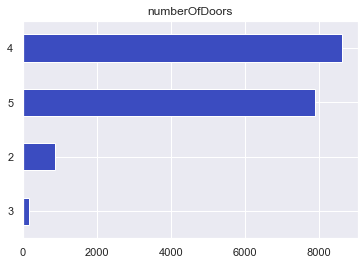

In [170]:
get_gr_counts(train, 'numberOfDoors')

Признак  numberOfDoors

5    1963
4    1594
2     244
3      36
Name: numberOfDoors, dtype: int64




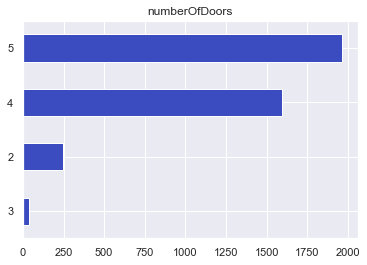

In [171]:
get_gr_counts(test, 'numberOfDoors')

**Вывод:** Обработка признака не требуется.

### Признак 'productionDate' - год производства
- Переведем в int
- По test посмотрим с каким периодом дат нам необходимо работать.
- Отфильтруем train под нужный период.
- Дальнейшие тесты показали, что скор выше, если убрать авто 2020 года выпуска из train (улучшается параметр пробега, уходят авто с пробегом 0).
- Попробовать логарифмировать признак.

In [172]:
test['productionDate'] = test['productionDate'].astype('int64')
print('Период исследования c', test['productionDate'].min(
), 'до', test['productionDate'].max(), 'год.')

Период исследования c 1981 до 2019 год.


In [173]:
train['filter_3'] = 0
test['filter_3'] = 0
train['filter_3'] = train['productionDate'].apply(
    lambda x: 1 if x < 1981 or x > 2019 else 0)
train['filter_3'].value_counts()

0    14670
1     2885
Name: filter_3, dtype: int64

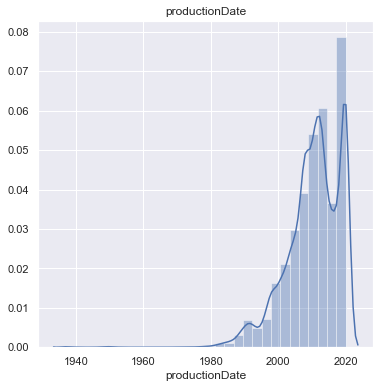

In [174]:
get_gr_num(train, 'productionDate', 30)

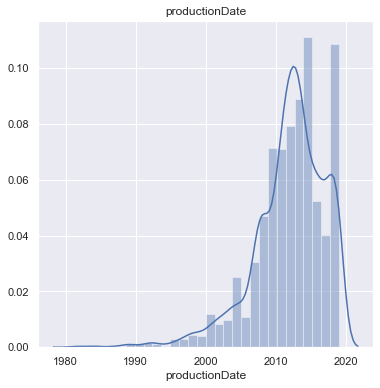

In [175]:
get_gr_num(test, 'productionDate', 30)

Удалим из train автомобили 2020 года выпуска.

In [176]:
train = train[train['productionDate'] != 2020]

### Признак 'vehicleConfiguration'

Признак  vehicleConfiguration

AUTOMATIC     12904
MECHANICAL     1678
ROBOT           128
Name: vehicleConfiguration, dtype: int64




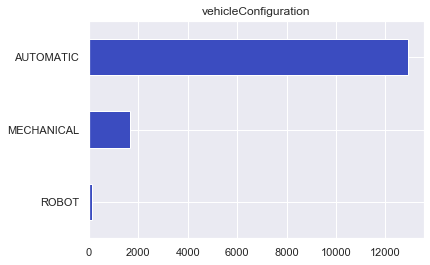

In [177]:
get_gr_counts(train, 'vehicleConfiguration')

In [178]:
test['vehicleConfiguration']

0                 SEDAN AUTOMATIC 2.0
1                 SEDAN AUTOMATIC 2.0
2                 SEDAN AUTOMATIC 4.4
3       ALLROAD_5_DOORS AUTOMATIC 3.0
4       ALLROAD_5_DOORS AUTOMATIC 3.0
                    ...              
3832              SEDAN AUTOMATIC 2.0
3833    ALLROAD_5_DOORS AUTOMATIC 3.0
3834              SEDAN AUTOMATIC 2.5
3835              SEDAN AUTOMATIC 2.0
3836    ALLROAD_5_DOORS AUTOMATIC 4.4
Name: vehicleConfiguration, Length: 3837, dtype: object

Приведем данные в test в соответствие данным в train

In [179]:
# Приводим test['vehicleConfiguration'] в соответствие с train
test['vehicleConfiguration'] = test['vehicleConfiguration'].apply(
    lambda x: 'ROBOT' if 'ROBOT' in x else 'MECHANICAL' if 'MECHANICAL' in x else 'AUTOMATIC')

### Признак 'engineDisplacement'
- В test и train разные данные в этом признаке.
- Приведем train в соответствие с test - объем двигателя.
- Переведем в int, предварительно умножив на 10, чтобы не потерять дробные части значений.

In [180]:
train['engineDisplacement'].head(3)

0    116i
1    320d
2    320i
Name: engineDisplacement, dtype: object

In [181]:
test['engineDisplacement'].head(3)

0    2.0 LTR
1    2.0 LTR
2    4.4 LTR
Name: engineDisplacement, dtype: object

In [182]:
# Обработка engineDisplacement
pattern = re.compile('\d\.\d')
train['engineDisplacement'] = train['name'].apply(lambda x: pattern.findall(x))
train['engineDisplacement'] = train['engineDisplacement'].apply(
    lambda x: x[0] if x != [] else 0)
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: x.replace(' LTR', ''))
test['engineDisplacement'] = test['engineDisplacement'].replace('undefined', 0)

# Перевод в int
train['engineDisplacement'] = train['engineDisplacement'].apply(
    lambda x: int(float(x)*10))
test['engineDisplacement'] = test['engineDisplacement'].apply(
    lambda x: int(float(x)*10))

### Признак 'enginePower' - мощность двигателя
- Данные совпадают, за исключением формата.
- Приведем формат test в соответствие с train

In [183]:
train['enginePower'].head(3)

0    136
1    184
2    184
Name: enginePower, dtype: int64

In [184]:
test['enginePower'].head(3)

0    190 N12
1    150 N12
2    407 N12
Name: enginePower, dtype: object

In [185]:
# Приводим test['enginePower'] в соответствие с train
test['enginePower'] = test['enginePower'].apply(
    lambda x: int(x.replace(' N12', '')))

### Признак 'description'
- Описание автомобиля.
- Из признака можно вытащить ключевые слова, влияющие на стоимость авто.
- Обработаем после объединения test и train для создания новых признаков.

### Признак 'mileage' - пробег автомобиля
- Формат данных в train и test совпадает.
- Переведем в int

In [186]:
test['mileage'] = test['mileage'].astype('int64')

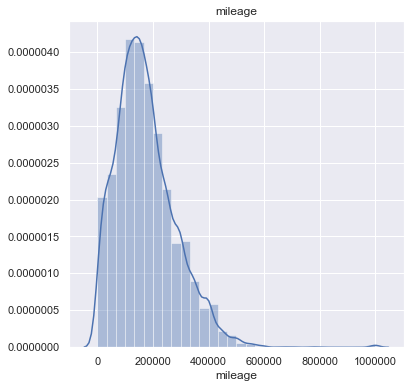

In [187]:
get_gr_num(train, 'mileage', 30)

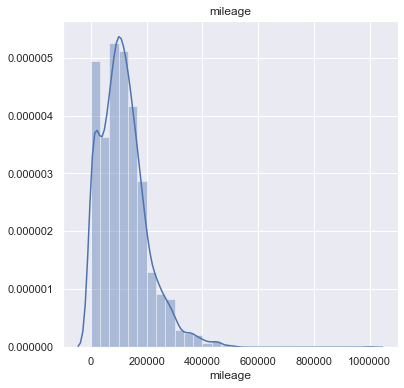

In [188]:
get_gr_num(test, 'mileage', 30)

### Признак 'Комплектация'
- В test данные идентичны данным из других признаков.
- В train очень много пропусков.
- Данный признак лучше удалить, как не несущий полезной информации. 

In [189]:
train['Комплектация'].head(3)

0    {'id': '7707468', 'name': '116i', 'available_o...
1                                          {'id': '0'}
2                                          {'id': '0'}
Name: Комплектация, dtype: object

In [190]:
test['Комплектация'].head(3)

0    ['[{"name":"Безопасность","values":["Антипробу...
1    ['[{"name":"Комфорт","values":["Круиз-контроль...
2    ['[{"name":"Комфорт","values":["Круиз-контроль...
Name: Комплектация, dtype: object

In [191]:
test = test.drop(['Комплектация'], axis=1)
train = train.drop(['Комплектация'], axis=1)

In [192]:
test.columns

Index(['bodyType', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'engineDisplacement',
       'enginePower', 'description', 'mileage', 'Привод', 'Руль', 'Владельцы',
       'ПТС', 'Таможня', 'Владение', 'description_Nan', 'owners_Nan',
       'pts_Nan', 'price', 'district_id', 'region_id', 'model', 'filter_1',
       'filter_2', 'd_in_name', 'i_in_name', '4WD_in_name', 'xDrive_in_name',
       'xi_in_name', 'L_in_name', 'hyb_in_name', 'sDrive_in_name',
       'sd_in_name', 'si_in_name', 'series', 'filter_3'],
      dtype='object')

### Признак 'Привод'

Признак  Привод

полный      7341
задний      7330
передний      39
Name: Привод, dtype: int64




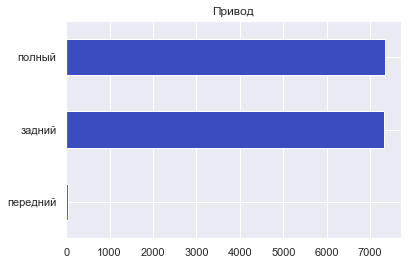

In [193]:
get_gr_counts(train, 'Привод')

Признак  Привод

полный      2444
задний      1378
передний      15
Name: Привод, dtype: int64




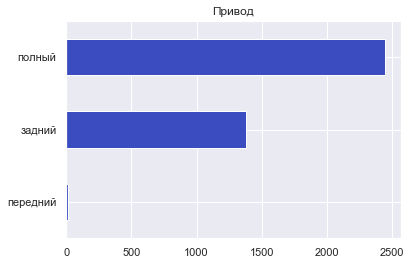

In [194]:
get_gr_counts(test, 'Привод')

**Вывод:** Данные совпадают, дополнительная обработка не требуется.

### Признак 'Руль'

Признак  Руль

LEFT     14708
RIGHT        2
Name: Руль, dtype: int64




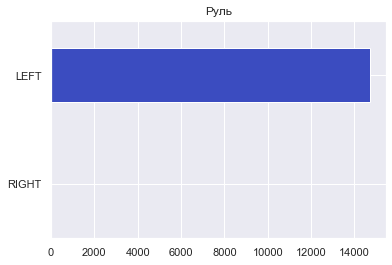

In [195]:
get_gr_counts(train, 'Руль')

Признак  Руль

Левый    3837
Name: Руль, dtype: int64




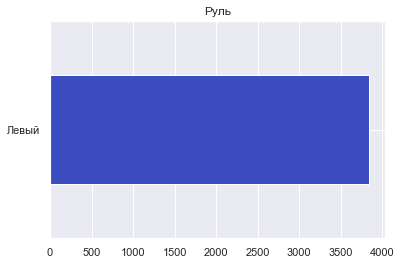

In [196]:
get_gr_counts(test, 'Руль')

В train присутствует 2 автомобиля с правым рулем, в test представлены автомобили исключительно с левым рулем.
- Удалим строки из train с автомобилями с правым рулем, т. к. они очевидно дешевле.
- Удалим данный признак, т. к. он не несет полезной информации.

In [197]:
train = train[train['Руль'] != 'RIGHT']
test = test.drop(['Руль'], axis=1)
train = train.drop(['Руль'], axis=1)

### Признак 'Владельцы'
- В train есть пропуски. В этом случае будем считать, что владелец 1
- Данные отличаются в train и test по формату.
- Приведем данные к единому формату int

Признак  Владельцы

3.0    8653
2.0    3468
1.0    2564
Name: Владельцы, dtype: int64




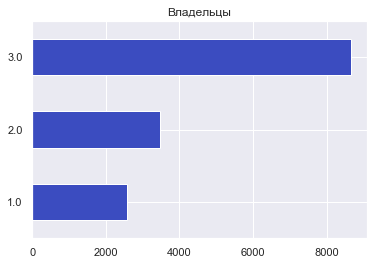

In [198]:
get_gr_counts(train, 'Владельцы')

Признак  Владельцы

3 или более    1516
1 владелец     1309
2 владельца    1012
Name: Владельцы, dtype: int64




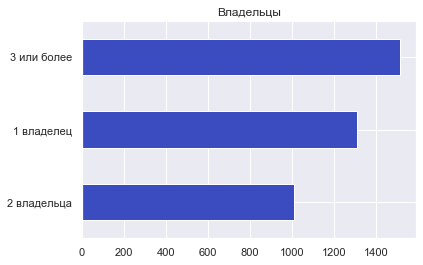

In [199]:
get_gr_counts(test, 'Владельцы')

In [200]:
# Владельцы (пропуски считаем, что владелец 1)
train['Владельцы'] = train['Владельцы'].fillna(1)
train['Владельцы'] = train['Владельцы'].astype('int64')

In [201]:
# Приводим test['Владельцы'] в соответствие с train
owners_dict = {
    '3 или более': 3,
    '1\xa0владелец': 1,
    '2\xa0владельца': 2
}

test['Владельцы'] = test['Владельцы'].replace(to_replace=owners_dict)

### Признак 'ПТС'
- В train есть пропуски. В этом случае будем считать, что ПТС Оригинал
- Данные отличаются в train и test по формату. Приведем их в соответствие друг другу.

Признак  ПТС

ORIGINAL     11799
DUPLICATE     2902
Name: ПТС, dtype: int64




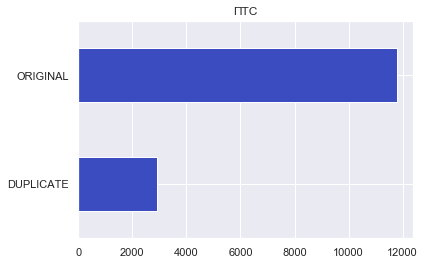

In [202]:
get_gr_counts(train, 'ПТС')

Признак  ПТС

Оригинал    3463
Дубликат     374
Name: ПТС, dtype: int64




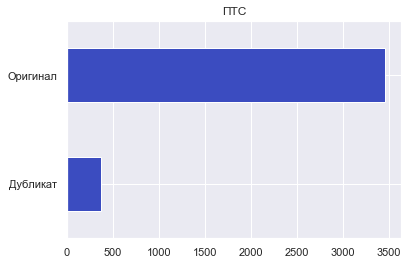

In [203]:
get_gr_counts(test, 'ПТС')

In [204]:
# ПТС (пропуски считаем, что ПТС Оригинал)
train['ПТС'] = train['ПТС'].fillna('Оригинал')

# Приводим train['ПТС'] в соответствие с test
pts_dict = {
    'ORIGINAL': 'Оригинал',
    'DUPLICATE': 'Дубликат'
}

train['ПТС'] = train['ПТС'].replace(to_replace=pts_dict)

### Признак 'Таможня'
- Все автомобили растаможены. Признак можно удалить, т. к. он не несет информации.

Признак  Таможня

True    14708
Name: Таможня, dtype: int64




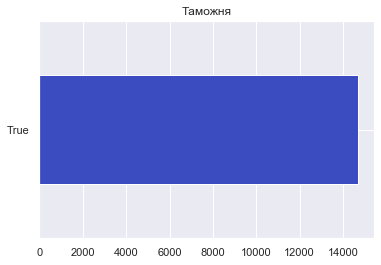

In [205]:
get_gr_counts(train, 'Таможня')

Признак  Таможня

Растаможен    3837
Name: Таможня, dtype: int64




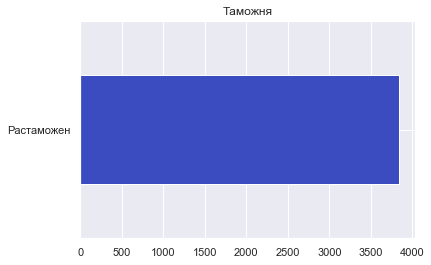

In [206]:
get_gr_counts(test, 'Таможня')

In [207]:
test = test.drop(['Таможня'], axis=1)
train = train.drop(['Таможня'], axis=1)

### Признак 'Владение'
- В train около 75% строк являются пропусками. Удалим данный параметр в дата сетах.

In [208]:
test = test.drop(['Владение'], axis=1)
train = train.drop(['Владение'], axis=1)

- Удалим признак 'name', т. к. мы взяли из него всю необходимую информацию.

In [209]:
test = test.drop(['name'], axis=1)
train = train.drop(['name'], axis=1)

### Создадим общий дата фрейм
Для упрощения создания новых признаков.
- Проверим, что датасеты имеют одинаковые наборы признаков

In [210]:
(set(test.columns) - set(train.columns)
 ) == (set(train.columns) - set(test.columns)) == set()

True

- Создадим параметр для последующего разделения дата сета на train и test.
- Создадим общий дата фрейм.

In [211]:
train['train'] = 1
test['train'] = 0
df = pd.concat([test, train])
df.head(5)

,bodyType,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,description,mileage,Привод,Владельцы,ПТС,description_Nan,...,filter_1,filter_2,d_in_name,i_in_name,4WD_in_name,xDrive_in_name,xi_in_name,L_in_name,hyb_in_name,sDrive_in_name,sd_in_name,si_in_name,series,filter_3,train
0,седан,чёрный,дизель,2016,4,2017,AUTOMATIC,20,190,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836,задний,1,Оригинал,0,...,0,0,1,0,0,0,0,0,0,0,0,0,5ER,0,0
1,седан,белый,дизель,2018,4,2019,AUTOMATIC,20,150,Автомобиль из демонстрационного парка по спец ...,10,задний,1,Оригинал,0,...,0,0,1,0,0,0,0,0,0,0,0,0,3ER,0,0
2,седан,синий,бензин,2009,4,2012,AUTOMATIC,44,407,Машина собиралась под заказ! \n\n,120000,полный,2,Оригинал,0,...,0,0,0,1,1,1,0,0,0,0,0,0,5ER,0,0
3,внедорожник 5 дв.,белый,дизель,2014,5,2015,AUTOMATIC,30,249,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466,полный,2,Оригинал,0,...,0,0,1,0,1,0,0,0,0,0,0,0,X5,0,0
4,внедорожник 5 дв.,синий,дизель,2014,5,2019,AUTOMATIC,30,381,Автомобиль не имеет собственников ( физ. лиц) ...,11891,полный,1,Оригинал,0,...,0,0,1,0,1,0,0,0,0,0,0,0,X5,0,0


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18545 entries, 0 to 17623
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              18545 non-null  object
 1   color                 18545 non-null  object
 2   fuelType              18545 non-null  object
 3   modelDate             18545 non-null  int64 
 4   numberOfDoors         18545 non-null  int64 
 5   productionDate        18545 non-null  int64 
 6   vehicleConfiguration  18545 non-null  object
 7   engineDisplacement    18545 non-null  int64 
 8   enginePower           18545 non-null  int64 
 9   description           18034 non-null  object
 10  mileage               18545 non-null  int64 
 11  Привод                18545 non-null  object
 12  Владельцы             18545 non-null  int64 
 13  ПТС                   18545 non-null  object
 14  description_Nan       18545 non-null  uint8 
 15  owners_Nan            18545 non-null

### Создание новых признаков
Средний пробег в год

In [213]:
df['mileage_prod_date'] = df['mileage'] / df['productionDate']
df['mileage_prod_date'] = df['mileage_prod_date'].astype('int64')

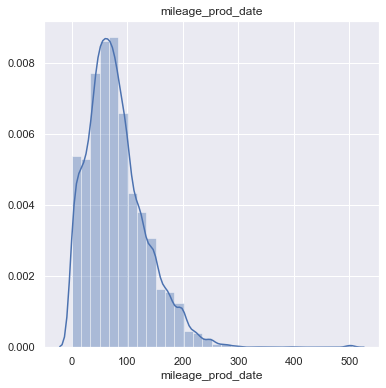

In [214]:
get_gr_num(df, 'mileage_prod_date', 30)

Пробег / кол-во владельцев (сколько владелец в среднем проезжал на авто)

In [215]:
df['mileage_owns'] = df['mileage'] / df['Владельцы']
df['mileage_owns'] = df['mileage_owns'].astype('int64')

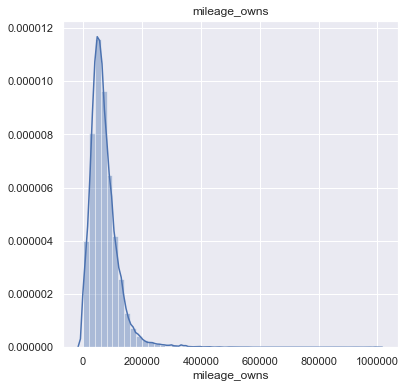

In [216]:
get_gr_num(df, 'mileage_owns', 50)

Среднее время владения автомобилем каждым владельцем.

In [217]:
df['owns_year'] = (2020-df['modelDate']) / df['Владельцы']
df['owns_year'] = df['owns_year'].astype('int64')

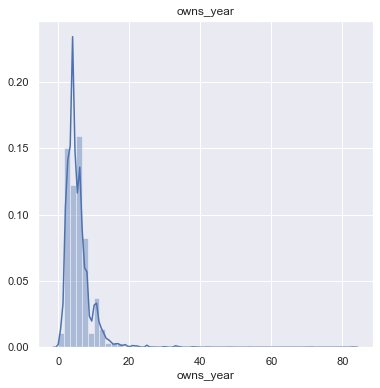

In [218]:
get_gr_num(df, 'owns_year', 50)

### Поработаем с description

In [219]:
# Фнукция работы с ключевыми словами описания
def features_from_description(df):
    # заполним пропуски в 'description'
    df['description'].fillna(' ', inplace=True)
    # разбиваем признак 'description' на наборы слов
    df['description_word'] = df['description'].apply(
        lambda x: [str(i).lower() for i in str(x).split()])
    # сделали признак с количеством слов в описании
    df['how_mach_words'] = df['description_word'].apply(lambda x: len(x))
    # каждый набор (список слов) из check_list будемформировать в демми признак
    # по принципу есть хоть что-то из списка
    check_list = [
        ['кожа', 'альконтара'],
        ['чип', 'апгрейд', 'stage'],
        ['бронир', 'плёнк', 'пленк'],
        ['круиз'],
        ['климат'],
        ['обогрев'],
        ['мультифункцион'],
        ['карбон'],
        ['доводчик'],
        ['камера'],
        ['парктро'],
        ['amg'],
        ['ксенон'],
        ['торг'],
        ['биксенон'],
        ['кредит'],
        ['ликвидация'],
        ['диски', 'литые', 'литьё'],
        ['панорам'],
        ['вмятина', 'царапина', 'замен', 'трещ',
         'брак', 'скол', 'притёрт', 'притерт'],
        ['покрашен', 'покрас'],
        ['авари', 'дтп'],
        ['сопрт', 'sport'],
        ['л.с.', 'лс', 'л. с.']
    ]

    def find_word(x, words=['кожа']):
        if len(x) > 0:
            for x_i in x:
                for w_i in words:
                    if w_i in x_i:
                        return 1
            return 0
        else:
            return 0
    k = 0
    for i in check_list:
        col_name = 'descr_' + str(k) + '_' + str(i[0])
        df[col_name] = df['description_word'].apply(find_word, i)
        k += 1

    # удаляем вспомогательную колонку
    df = df.drop(['description_word'], axis=1)

    return df


df = features_from_description(df)

Распределение признака 'how_mach_words'

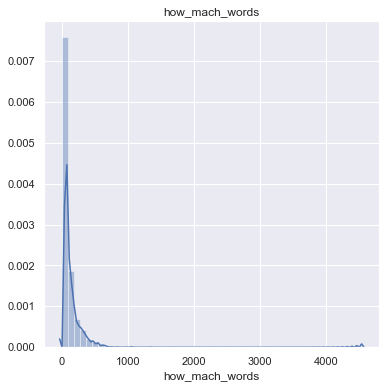

In [220]:
get_gr_num(df, 'how_mach_words', 50)

- Векторизация описания и вытаскивание из этого пары признаков

In [221]:
vectorizer = CountVectorizer(
    max_df=0.8,  # отсекаем слова, которые попадаются в 80% случаев
    min_df=0.005,  # отскеаем слова редкие, которые встречаются реже 0,5%
    max_features=1000)

text_feat = vectorizer.fit_transform(df['description'].fillna(' '))

df['mean'] = text_feat.mean(axis=1)
df['mean'] = df['mean'].apply(lambda x: int(x*1000))
df['sum'] = text_feat.sum(axis=1)

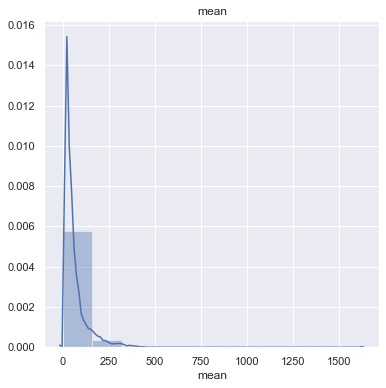

In [222]:
get_gr_num(df, 'mean', 10)

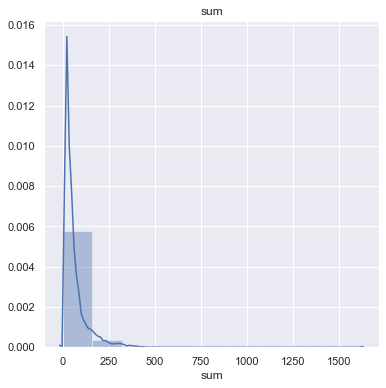

In [223]:
get_gr_num(df, 'sum', 10)

- Удалим description

In [224]:
df = df.drop(['description'], axis = 1)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18545 entries, 0 to 17623
Data columns (total 65 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   bodyType                18545 non-null  object
 1   color                   18545 non-null  object
 2   fuelType                18545 non-null  object
 3   modelDate               18545 non-null  int64 
 4   numberOfDoors           18545 non-null  int64 
 5   productionDate          18545 non-null  int64 
 6   vehicleConfiguration    18545 non-null  object
 7   engineDisplacement      18545 non-null  int64 
 8   enginePower             18545 non-null  int64 
 9   mileage                 18545 non-null  int64 
 10  Привод                  18545 non-null  object
 11  Владельцы               18545 non-null  int64 
 12  ПТС                     18545 non-null  object
 13  description_Nan         18545 non-null  uint8 
 14  owners_Nan              18545 non-null  uint8 
 15  pt

### Категориальные признаки
- Создадим список категориальных признаков для передачи списка в классификатор cat boost или для преобразования признаков в dummy-переменные в случае использования других моделей.

In [226]:
cat_cols = ['bodyType', 'color', 'fuelType',
            'vehicleConfiguration', 'Привод', 'ПТС', 'model', 'series']

### Числовые признаки
- Логарифмируем числовые признаки.

In [227]:
num_cols = ['modelDate', 'productionDate', 'mileage', 'mileage_prod_date',
            'mileage_owns', 'owns_year', 'how_mach_words', 'mean', 'sum', 'price']

## Создадим варианты дата сетов для тестирования моделей
- df_0_0_0 - наиболее полный дата сет, без удаления строк.
- df_1_1_1 - дата сет наиболее приближенный к test (удалены все строк, которые не соответствуют test).
- Остальные дата сеты - промежуточные варианты для тестирования.

In [228]:
df_0_0_0 = df.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [229]:
df_1_1_1 = df.query('filter_1 == 0 & filter_2 == 0 & filter_3 == 0')
df_1_1_1 = df_1_1_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [230]:
df_0_0_1 = df.query('filter_3 == 0')
df_0_0_1 = df_0_0_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [231]:
df_0_1_0 = df.query('filter_2 == 0')
df_0_1_0 = df_0_1_0.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [232]:
df_1_0_0 = df.query('filter_1 == 0')
df_1_0_0 = df_1_0_0.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [233]:
df_0_1_1 = df.query('filter_2 == 0 & filter_3 == 0')
df_0_1_1 = df_0_1_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [234]:
df_1_0_1 = df.query('filter_1 == 0 & filter_3 == 0')
df_1_0_1 = df_1_0_1.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

In [235]:
df_1_1_0 = df.query('filter_1 == 0 & filter_2 == 0')
df_1_1_0 = df_1_1_0.drop(['filter_1', 'filter_2', 'filter_3'], axis=1)

## Выбор моделей и подбор гиперпараметров

### Catboost

In [236]:
#разобьем выборку на тест и трейн
train = df_0_0_0[df_0_0_0.train == 1].drop('train', axis = 1)#titanic_train
test = df_0_0_0[df_0_0_0.train == 0].drop(['train', 'price'], axis = 1) #titanic_test

In [237]:
# Подготовим данные для обучения модели
X = train.drop(['price'], axis=1) #titanic_train
y = train.price.values #titanic_train_target

In [238]:
model = catboost.CatBoostRegressor(iterations=1000)

In [239]:
train_pool = catboost.Pool(X, y, cat_features=cat_cols)
test_pool = catboost.Pool(test, cat_features=cat_cols)

In [240]:
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 8, 10, 12],
    'l2_leaf_reg': [0,5, 1, 3, 5, 7, 9],
    'iterations': [1000, 2000, 3000, 4000, 5000, 6000],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS', None],
    #'eval_metric': ['MAPE'],
    'od_type': ['Iter', 'IncToDec']  
}
grid_search_results = model.grid_search(grid, train_pool, shuffle=False, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 228364.985
bestIteration = 999

0:	loss: 228364.9850022	best: 228364.9850022 (0)	total: 44.4s	remaining: 1d 17h 23m 49s

bestTest = 224585.3105
bestIteration = 994

1:	loss: 224585.3105100	best: 224585.3105100 (1)	total: 1m 28s	remaining: 1d 17h 6m 29s

bestTest = 219956.8965
bestIteration = 999

2:	loss: 219956.8965485	best: 219956.8965485 (2)	total: 2m 11s	remaining: 1d 16h 45m 16s

bestTest = 228364.985
bestIteration = 999

3:	loss: 228364.9850022	best: 219956.8965485 (2)	total: 2m 53s	remaining: 1d 16h 31m 41s

bestTest = 224585.3105
bestIteration = 994

4:	loss: 224585.3105100	best: 219956.8965485 (2)	total: 3m 35s	remaining: 1d 16h 8m 54s

bestTest = 219956.8965
bestIteration = 999

5:	loss: 219956.8965485	best: 219956.8965485 (2)	total: 4m 17s	remaining: 1d 15h 57m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 221596.5903
bestIteration = 630

6:	loss: 221596.5902536	best: 219956.8965485 (2)	total: 4m 45s	remaining: 1d 13h 56m 36s
Stopped by ov

Stopped by overfitting detector  (20 iterations wait)

bestTest = 227556.3539
bestIteration = 485

55:	loss: 227556.3538701	best: 206192.8355859 (10)	total: 37m 31s	remaining: 1d 12h 53m 36s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 215997.0887
bestIteration = 770

56:	loss: 215997.0886601	best: 206192.8355859 (10)	total: 38m 9s	remaining: 1d 12h 51m 15s

bestTest = 218959.4531
bestIteration = 992

57:	loss: 218959.4530527	best: 206192.8355859 (10)	total: 39m 1s	remaining: 1d 13h 1m 33s

bestTest = 216099.355
bestIteration = 997

58:	loss: 216099.3549558	best: 206192.8355859 (10)	total: 39m 49s	remaining: 1d 13h 8m 37s

bestTest = 212889.1364
bestIteration = 986

59:	loss: 212889.1364321	best: 206192.8355859 (10)	total: 40m 38s	remaining: 1d 13h 15m 5s

bestTest = 238116.4169
bestIteration = 994

60:	loss: 238116.4168748	best: 206192.8355859 (10)	total: 41m 27s	remaining: 1d 13h 22m 28s

bestTest = 234184.7105
bestIteration = 998

61:	loss: 234184.7105228	best: 

Stopped by overfitting detector  (20 iterations wait)

bestTest = 224343.3972
bestIteration = 1364

108:	loss: 224343.3971990	best: 201389.6896838 (94)	total: 1h 27m 18s	remaining: 1d 19h 24m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 225530.1018
bestIteration = 1196

109:	loss: 225530.1018289	best: 201389.6896838 (94)	total: 1h 28m 12s	remaining: 1d 19h 26m 8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 218686.3094
bestIteration = 1268

110:	loss: 218686.3094032	best: 201389.6896838 (94)	total: 1h 29m 9s	remaining: 1d 19h 29m 43s

bestTest = 218992.1936
bestIteration = 1999

111:	loss: 218992.1936323	best: 201389.6896838 (94)	total: 1h 30m 40s	remaining: 1d 19h 49m 37s

bestTest = 217702.272
bestIteration = 1999

112:	loss: 217702.2720214	best: 201389.6896838 (94)	total: 1h 32m 7s	remaining: 1d 20h 7m 6s

bestTest = 214820.9764
bestIteration = 1992

113:	loss: 214820.9763768	best: 201389.6896838 (94)	total: 1h 33m 36s	remaining: 1d 20h 2

Stopped by overfitting detector  (20 iterations wait)

bestTest = 227512.112
bestIteration = 1499

158:	loss: 227512.1120140	best: 201389.6896838 (94)	total: 2h 26m 22s	remaining: 2d 1h 6m 48s

bestTest = 226579.7803
bestIteration = 1999

159:	loss: 226579.7803108	best: 201389.6896838 (94)	total: 2h 28m 4s	remaining: 2d 1h 21m 23s

bestTest = 225328.1857
bestIteration = 1999

160:	loss: 225328.1857066	best: 201389.6896838 (94)	total: 2h 29m 27s	remaining: 2d 1h 29m 33s

bestTest = 224191.484
bestIteration = 1999

161:	loss: 224191.4839760	best: 201389.6896838 (94)	total: 2h 30m 47s	remaining: 2d 1h 36m 40s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 220927.7449
bestIteration = 1029

162:	loss: 220927.7448504	best: 201389.6896838 (94)	total: 2h 31m 31s	remaining: 2d 1h 31m 50s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 232946.1804
bestIteration = 428

163:	loss: 232946.1804201	best: 201389.6896838 (94)	total: 2h 31m 49s	remaining: 2d 1h 18m 4


bestTest = 216615.8529
bestIteration = 2999

207:	loss: 216615.8529128	best: 200348.4453050 (178)	total: 3h 33m 59s	remaining: 2d 6h 2m 46s

bestTest = 214849.5313
bestIteration = 2990

208:	loss: 214849.5313428	best: 200348.4453050 (178)	total: 3h 36m 39s	remaining: 2d 6h 26m 34s

bestTest = 212597.5087
bestIteration = 2980

209:	loss: 212597.5087204	best: 200348.4453050 (178)	total: 3h 38m 43s	remaining: 2d 6h 40m 56s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 236150.5442
bestIteration = 285

210:	loss: 236150.5441945	best: 200348.4453050 (178)	total: 3h 38m 56s	remaining: 2d 6h 27m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 220779.0435
bestIteration = 561

211:	loss: 220779.0434928	best: 200348.4453050 (178)	total: 3h 39m 19s	remaining: 2d 6h 16m 53s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 216808.8156
bestIteration = 631

212:	loss: 216808.8156047	best: 200348.4453050 (178)	total: 3h 39m 46s	remaining: 2d 6


bestTest = 207750.2371
bestIteration = 3942

256:	loss: 207750.2370792	best: 200348.4453050 (178)	total: 4h 54m 2s	remaining: 2d 11h 10m 11s

bestTest = 208405.1529
bestIteration = 3839

257:	loss: 208405.1528595	best: 200348.4453050 (178)	total: 4h 56m 49s	remaining: 2d 11h 28m 46s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 221596.5903
bestIteration = 630

258:	loss: 221596.5902536	best: 200348.4453050 (178)	total: 4h 57m 19s	remaining: 2d 11h 19m 51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 209009.7656
bestIteration = 808

259:	loss: 209009.7655678	best: 200348.4453050 (178)	total: 4h 57m 54s	remaining: 2d 11h 12m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 214969.4084
bestIteration = 497

260:	loss: 214969.4084375	best: 200348.4453050 (178)	total: 4h 58m 16s	remaining: 2d 11h 1m 34s

bestTest = 205200.4538
bestIteration = 3852

261:	loss: 205200.4537530	best: 200348.4453050 (178)	total: 5h 1m 9s	remaining: 2d 


bestTest = 212309.0242
bestIteration = 3997

305:	loss: 212309.0241587	best: 199147.9011315 (262)	total: 6h 28m 57s	remaining: 2d 16h 41m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 227972.8332
bestIteration = 512

306:	loss: 227972.8331840	best: 199147.9011315 (262)	total: 6h 29m 19s	remaining: 2d 16h 31m 44s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 227556.3539
bestIteration = 485

307:	loss: 227556.3538701	best: 199147.9011315 (262)	total: 6h 29m 40s	remaining: 2d 16h 21m 20s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 215997.0887
bestIteration = 770

308:	loss: 215997.0886601	best: 199147.9011315 (262)	total: 6h 30m 13s	remaining: 2d 16h 12m 57s

bestTest = 207336.6991
bestIteration = 3976

309:	loss: 207336.6990602	best: 199147.9011315 (262)	total: 6h 33m	remaining: 2d 16h 26m 46s

bestTest = 202630.7245
bestIteration = 3959

310:	loss: 202630.7244833	best: 199147.9011315 (262)	total: 6h 35m 45s	remaining: 2d

KeyboardInterrupt: 

Код выполнялся ну очень долго, часов 5, при этом он проделал только 10% работы. Так что я остановил код

### Деревья

Создадим временный дата фрейм с dummy-переменными из категориальных признаков.

In [242]:
df_tmp = df_0_0_0
df_tmp = pd.get_dummies(df_tmp, columns=cat_cols)

In [243]:
#разобьем на тест и трейн
train = df_tmp[df_tmp.train == 1].drop('train', axis = 1)
test = df_tmp[df_tmp.train == 0].drop(['train', 'price'], axis = 1) 

In [244]:
# Подготовим данные для обучения модели
X = train.drop(['price'], axis=1) 
y = train.price.values 

сделаем фукнцию для подбора гиперпараметров для деревьев

In [245]:
def grid_search(model, param):

    # Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

    # Fit
    model_grid = GridSearchCV(estimator=model, param_grid=param, cv=5, verbose=2, n_jobs=1)
    model_grid.fit(X_train, y_train)

    # Показать лучшие параметры
    print(model_grid.best_params_)

    # Показать лучший score
    print(model_grid.best_score_)

In [246]:
# Гиперпараметры для случайного леса и экстрадеревьев
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [247]:
grid_search(RandomForestRegressor(random_state=RANDOM_SEED), grid)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=  15.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=  15.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=  15.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=  15.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  20.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  16.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  17.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  23.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   8.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   7.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   7.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   7.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=  23.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=  30.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=  30.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=  29.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   8.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=   9.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=   9.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=  10.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=  15.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=  14.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=  14.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=  14.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   6.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=  14.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=  14.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=  21.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=  21.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   9.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   7.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   9.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   9.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=  27.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=  26.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_f

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   9.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   9.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=  11.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=  10.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=  13.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=  12.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=  12.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  13.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=1

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_dept

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_fea

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_dep

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  22.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  22.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  21.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=  32.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=  11.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  38.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  38.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  38.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=  12.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=  12.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=  12.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=  12.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  17.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  36.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  22.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  21.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   9.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   9.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   9.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  34.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  36.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  34.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  34.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=  10.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=  13.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=  12.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=  12.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=  40.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=  39.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, ma

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=  13.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=  13.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=  16.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=  15.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=  30.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=  17.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=  17.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=  17.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=  10.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=  11.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=  25.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=  25.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=  26.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=  42.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, m

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_f

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  14.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  20.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  16.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=  21.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=30, max_feat

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  47.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  46.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  54.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   2.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=  16.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=  17.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=  16.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=  19.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=30, max_feat

KeyboardInterrupt: 

In [248]:
grid_search(ExtraTreesRegressor(random_state=RANDOM_SEED), grid)

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   8.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   9.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   8.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=80, total=   8.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=30, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   9.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   9.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   9.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   9.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   4.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=  17.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=  20.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=  20.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=  22.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=  10.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=   7.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=   9.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70, total=   8.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   8.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   8.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=  10.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90, total=   9.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   9.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   9.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=  14.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=  14.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   7.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   8.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=  10.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=  25.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=  28.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_f

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   7.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=  16.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=  22.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=  15.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   8.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   8.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   8.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   9.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=1

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_dept

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_fea

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=80, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=10, max_feat

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=10, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   6.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40, total=   6.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  15.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  15.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=  24.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=  23.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   8.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  26.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  26.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   8.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   8.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=70, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=   9.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  11.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  11.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  11.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=90, total=  11.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_fea

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=40, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  19.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  18.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  18.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=150, total=  18.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   6.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   7.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60, total=   6.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=  23.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_fe

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   9.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   9.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=  10.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=  11.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=  11.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, total=  11.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, m

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=  16.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=  16.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=  16.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=  21.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=80, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=30, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, m

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=70, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=30, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=70, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=90, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_f

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=40, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=60, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=40, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=150, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=70 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=10, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=80, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=True, max_depth=20, max_feat

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=30 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=40 
[CV]  bootstrap=True, max_depth=20, 

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=150 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   9.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   9.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   9.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60, total=  11.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=60 
[CV]  bootstrap=True, max_depth=30, max_feat

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  35.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  35.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=  36.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10 
[CV]  bootstrap=True, max_depth=30, max

KeyboardInterrupt: 

In [249]:
# Сетка гиперпараметров для решающих дереврьев
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

grid_search(DecisionTreeRegressor(random_state=RANDOM_SEED), grid)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=10, max_features=auto, min

[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=10, max_features=sqrt, min

[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=10, max_features=log

[CV]  max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.5s
[CV] max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, total=   0.5s
[CV] max_depth=20, max_features=

[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.2s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.2s
[CV] max_depth=20, max_features=sqrt, mi

[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=20, max_features=log2, min

[CV]  max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, total=   0.4s
[CV] max_depth=30, max_features=auto, m

[CV]  max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, total=   0.2s
[CV] max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=s

[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=30, max_features=lo

[CV]  max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, total=   0.4s
[CV] max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   0.4s
[CV] max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   0.3s
[CV] max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   0.4s
[CV] max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   0.4s
[CV] max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   0.4s
[CV] max_depth=40, max_features=auto, mi

[CV]  max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=sqrt, min

[CV]  max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=40, max_features=log

[CV]  max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.4s
[CV] max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.4s
[CV] max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.4s
[CV] max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.4s
[CV] max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.4s
[CV] max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=50, max_features=

[CV]  max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.1s
[CV] max_depth=50, max_features=log2, 

[CV]  max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.4s
[CV] max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.4s
[CV] max_depth=60, max_features=auto, min

[CV]  max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=60, max_features=sqrt, min

[CV]  max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=60, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.1s
[CV] max_depth=60, max_features=log

[CV]  max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, total=   0.4s
[CV] max_depth=70, max_features=

[CV]  max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, total=   0.2s
[CV] max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=sqrt, mi

[CV]  max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=2, total=   0.1s
[CV] max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=70, max_features=log2, min_samples_leaf=2, min_samples_split=5, total=   0.1s
[CV] max_depth=70, max_features=log2, min

[CV]  max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   0.4s
[CV] max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, total=   0.4s
[CV] max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, total=   0.4s
[CV] max_depth=80, max_features=auto,

[CV]  max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, total=   0.2s
[CV] max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, total=   0.2s
[CV] max_depth=80, max_features

[CV]  max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.2s
[CV] max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=80, max_features=log2, min_samples_leaf=2, min_samples_split=10, total=   0.1s
[CV] max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=2, total=   0.2s
[CV] max_depth=80, max_features=log2

[CV]  max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   1.3s
[CV] max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   1.4s
[CV] max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   1.0s
[CV] max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   1.4s
[CV] max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, total=   1.0s
[CV] max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   1.2s
[CV] max_depth=90, max_features=auto, min

[CV]  max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.1s
[CV] max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.2s
[CV] max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.2s
[CV] max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   0.1s
[CV] max_depth=90, max_features=sqrt, min

[CV]  max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.2s
[CV] max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.4s
[CV] max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.2s
[CV] max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=5, total=   0.2s
[CV] max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.3s
[CV] max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=90, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.2s
[CV] max_depth=90, max_features=log2,

[CV]  max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   0.6s
[CV] max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   0.5s
[CV] max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.7s
[CV] max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.5s
[CV] max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.6s
[CV] max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.8s
[CV] max_depth=100, ma

[CV]  max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, total=   0.1s
[CV] max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=100, m

[CV]  max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.3s
[CV] max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.5s
[CV] max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10 
[CV]  max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=10, total=   0.3s
[CV] max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   1.5s
[CV] max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   2.0s
[CV] max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.8s
[CV] max_depth=110, max_f

[CV]  max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, total=   0.8s
[CV] max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.3s
[CV] max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.3s
[CV] max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_featu

[CV]  max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, total=   0.2s
[CV] max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.1s
[CV] max_depth=110, max_featur

[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, total=   0.5s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.6s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.5s
[CV] max_depth=None

[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, total=   0.2s
[CV] max_depth=No

[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.3s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, total=   0.2s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.2s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.3s
[CV] max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, total=   0.4s
[CV] max_dept

[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  8.2min finished


{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10}
0.9204107978244046


По итогу были подобраны гиперпараметры для 3х моделей, которые далее будем использовать для стекинга

## Stacking

снова разобьем выборку на трейн и тест

In [250]:
train = df_1_1_0[df_1_1_0.train == 1].drop('train', axis=1)
test = df_1_1_0[df_1_1_0.train == 0].drop(['train', 'price'], axis=1)

__Были испробованы следующие способы и комбинации:__

1) катбуст с гиперпараметрами по умолчанию

2) катбуст с гиперпараметрами, подобранными руками

3) случайный лес

4) катбуст и кросс-валидация

5) случайный лес и кросс-валидация

6) стекинг, при котором производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения (катбуст+случайный лес) - для обоих алгоритмов один датафрейм 

7) стекинг, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке (случайный лес+деревья)- для обоих алгоритмов один датафрейм 


8) стекинг, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке (комбинация случайного леса, катбуста, решающих деревьев и экстрадеревьев, по итогу самый лучший скор - это катбуст+экстрадеревья+решающие деревья)- для каждого алгоритма свой датафрейм, и этот вариант в итоге был самым эффективным - результат 11.45533 на кэгле. Если использовать функцию для стекинга, то надо, чтобы датафрейм был одинаковый, а для катбуста хороши текстовые фичи, но это не подходит для лесов.

### Функции для стекинга

вот пример функции для стекинга, при котором производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения

In [251]:
# Получаем из базового алгоритма фичи для мета-алгоритма
# Подаем на вход регрессор, выборки и кол-во разбиений
# Для одного (каждого) регрессора
def compute_meta_feature(rgs, X_train, X_test, y_train, cv):
    # Делаем массивы нулей, чтобы потом его заполнить значениями
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    X_meta_test = np.zeros(len(X_test), dtype=np.float32)
    # Разбиваем на фолды тренировочную выборку (получаем индексы)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train.iloc[train_fold_index], X_train.iloc[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        # Клонируем классификатор, чтобы его использовать на всех фолдах
        folded_rgs = clone(rgs)
        # если модель - это катбуст, то передаем еще несколько параметров
        # Обучаем
        if type(rgs).__name__ == 'CatBoostRegressor':
            #folded_clf.fit(X_fold_train, y_fold_train, cat_features=cat_cols, verbose_eval = 100)
            folded_rgs.fit(X_fold_train, y_fold_train, verbose_eval=100)
        else:
            folded_rgs.fit(X_fold_train, y_fold_train)
  # Предсказываем и постепенно записываем в наш массив
        # Получаем массив трейн для мета-классификатора
        X_meta_train[predict_fold_index] = folded_rgs.predict(X_fold_predict)
    # Далее на каждом шаге, где мы обучаем folded_rgs.fit (X_fold_train, y_fold_train)
    # и его предсказания на X_fold_predict запихиваем в X_meta_train[predict_fold_index]
    # добавим еще одну строку, где в X_meta_test будем добавлять предсказания вероятностей folded_cl на X_test.
    # Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить,
    # а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);
    # я выбрала вариант сразу складывать друг с другом
        X_meta_test += folded_rgs.predict(X_test)
# Предсказываем на тесте, но это будет не y_pred а X_test для мета-классификатора
# После цикла останется только усреднить все эти массивы, это и будет наш X_meta_tes.
    X_meta_test = X_meta_test / cv.n_splits
# Возвращаем тренировочную и тестовую выборки для мета-классификатора
    return X_meta_train, X_meta_test


# Функция прогоняет несколько классификаторов через предыдущую функцию и делает стекинг
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    features = [
        compute_meta_feature(rgs, X_train, X_test, y_train, cv)
        for rgs in tqdm(classifiers)
    ]

    stacked_features_train = np.stack([
        features_train for features_train, features_test in features
    ], axis=-1)

    stacked_features_test = np.stack([
        features_test for features_train, features_test in features
    ], axis=-1)

    return stacked_features_train, stacked_features_test

In [ ]:
вот пример функции для стекинга, при котором для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке 

In [252]:
# Получаем из базового алгоритма фичи для мета-алгоритма
# Подаем на вход регрессор, выборки и кол-во разбиений
# Для одного (каждого) регрессора
def compute_meta_feature(rgs, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.

    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    # Делаем массив нулей, чтобы потом его заполнить значениями
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    # Разбиваем на фолды тренировочную выборку (получаем индексы)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        # Клонируем классификатор, чтобы его использовать на всех фолдах
        folded_rgs = clone(rgs)
        # Обучаем
        folded_rgs.fit(X_fold_train, y_fold_train)
        # Предсказываем и постепенно записываем в наш массив
        # Получаем массив трейн для мета-классификатора
        X_meta_train[predict_fold_index] = folded_rgs.predict(X_fold_predict)

    # Получаем массив тест для мета-классификатора
    # Обучаем тот же классификатор на всей выборке трейн
    meta_rgs = clone(rgs)
    meta_rgs.fit(X_train, y_train)

    # Предсказываем на тесте, но это будет не y_pred а X_test для мета-классификатора
    X_meta_test = meta_rgs.predict(X_test)

    # Возвращаем тренировочную и тестовую выборки для мета-классификатора
    return X_meta_train, X_meta_test

In [253]:
# Функция прогоняет несколько классификаторов через предыдущую функцию и делает стекинг
def generate_metafeatures(regressors, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.

    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(rgs, X_train, X_test, y_train,
                             cv)  # Наша предыдущая функция
        for rgs in tqdm(classifiers)
    ]

    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T
    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T

    return stacked_features_train, stacked_features_test

Как было указано выше, не получается "обернуть" стекинг в функцию из-за особенностей катбуста, поэтому будем для каждой модели сделаем все шаги отдельно

### Собственно сам стекинг

In [254]:
n_foldes = 5
cv = KFold(n_splits=n_foldes, shuffle=True, random_state=RANDOM_SEED)

X = train.drop(['price'], axis=1,)


#ранее было отмечено, что распределение у таргета логнормальное, поэтому прологарифмируем таргет, чтобы сделать распределение нормальным
y = np.array(train.price.apply(lambda i: np.log(i)))

X_meta_train_features = []
X_meta_test_features = []

# 1 - catboost

model = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          l2_leaf_reg=0.5,
                          depth=12,
                          od_type='Iter',
                          od_wait=50,
                          bootstrap_type='Bayesian',
                          bagging_temperature=0.1,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'])

X_meta_train = np.zeros_like(y, dtype=np.float32)
X_meta_test = np.zeros(len(test), dtype=np.float32)
for train_fold_index, predict_fold_index in cv.split(X):
    X_fold_train, X_fold_predict = X.iloc[train_fold_index], X.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]
    y_fold_test = y[predict_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train,
                     cat_features=cat_cols,
                     eval_set=(X_fold_predict, y_fold_test),
                     verbose_eval=500,
                     use_best_model=True,
                     plot=False
                     )
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    X_meta_test += folded_model.predict(test)


X_meta_test = X_meta_test / n_foldes

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

0:	learn: 0.0451104	test: 0.0448371	best: 0.0448371 (0)	total: 1.2s	remaining: 39m 54s
500:	learn: 0.0013349	test: 0.0085248	best: 0.0085225 (493)	total: 5m 43s	remaining: 17m 8s
1000:	learn: 0.0003518	test: 0.0084439	best: 0.0084437 (999)	total: 11m 48s	remaining: 11m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.008429546866
bestIteration = 1416

Shrink model to first 1417 iterations.
0:	learn: 0.0449917	test: 0.0445710	best: 0.0445710 (0)	total: 662ms	remaining: 22m 2s
500:	learn: 0.0013328	test: 0.0089087	best: 0.0089078 (499)	total: 5m 43s	remaining: 17m 7s
1000:	learn: 0.0003618	test: 0.0088499	best: 0.0088496 (973)	total: 11m 6s	remaining: 11m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.008847164505
bestIteration = 1083

Shrink model to first 1084 iterations.
0:	learn: 0.0448774	test: 0.0450222	best: 0.0450222 (0)	total: 541ms	remaining: 18m 1s
500:	learn: 0.0013277	test: 0.0087593	best: 0.0087593 (500)	total: 5m 36s	remaining

In [165]:
# 2 - randomForestRegressor

model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

X_meta_train = np.zeros_like(y, dtype=np.float32)
X_train_num = X.drop(cat_cols, axis=1)
test_num = test.drop(cat_cols, axis=1)

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(test_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parall

собираем метафичи

In [255]:
stacked_features_train = np.vstack(X_meta_train_features).T
stacked_features_test = np.vstack(X_meta_test_features).T

В качестве метафункции были протестированы линейная регрессия, Ридж, Лассо и Эластикнет. Лучший скор у Риджа

In [259]:
# используем гридсерч для поиска гиперпараметров
rgs = Ridge()
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 0.5, 0.1, 1, 5, 10,
                        20], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid_ridge = GridSearchCV(
    estimator=rgs, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_ridge.fit(stacked_features_train, y)
grid_ridge.best_params_

{'alpha': 1e-08, 'solver': 'saga'}

In [268]:
# запихиваем подобранные гиперпараметры в модель и обучаем
rgs = Ridge(alpha=1e-10, solver='sag', random_state=RANDOM_SEED)
rgs.fit(stacked_features_train, y)

Ridge(alpha=1e-10, random_state=25, solver='sag')

In [267]:
# предсказываем
pred = rgs.predict(stacked_features_test)
# экспоненциируем предсказанные цены, так как ранее логарфимировали
pred = np.exp(pred)

### MAPE

In [269]:
# Расчет MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [270]:
mape(y, pred)

ValueError: operands could not be broadcast together with shapes (3837,) (13788,) 

3837

## Submission

In [170]:
sample_submission['price'] = pred

Были протестированы варианты уменьшения цены на 5, 10, 12, 13, 15, 20 процентов и округления на 1, 5, 10, 50 и 100 тыс. Лучший скор получился если итоговые предсказания умножить на 0.9 (то есть уменьшение на 10%) и потом округлить до 5 тыс.

In [171]:
# Введем понижающий коэфиициент, чтобы привести текущие цены к ценам, которые были когда создавалось соревновение
sample_submission['price'] = sample_submission['price'] * 0.9  # Минус 10%
# Округление до 5 000
sample_submission['price'] = np.round(sample_submission['price']*2, -4)/2
# сохранить в файл
sample_submission[['id', 'price']].to_csv(
    f'submission_v_staking_ridge_gr_110.csv', index=False)